In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame

from math import sqrt
from numpy import concatenate
from pandas import concat
from numpy import ndarray

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# fungsi untuk merubah data menjadi supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
case = pd.read_csv('data/new/case_maret_july.csv')
case.set_index('date', inplace=True)

In [4]:
len(case)

423

In [15]:
# Ambil data untuk evaluasi
#data_evaluasi = case[413:]

validation_size = 10
validation_size = len(case) - validation_size
train, validation = case[0:validation_size], case[validation_size:len(case)]

#total split data untuk LSTM
n_total = len(train)

#jumlah neuron
neu = int(2/3*(n_total+1))
jumlah_neuron = neu

# Parameter untuk LSTM
epooch_total = 100
size_batch = 1

print(neu)

276


In [6]:
# ubah data menjadi supervised learning problem
reframed = series_to_supervised(train, 2, 1)
reframed

,var1(t-2),var1(t-1),var1(t)
date,,,
2020-03-20,38.0,50.0,14
2020-03-21,50.0,14.0,44
2020-03-22,14.0,44.0,36
2020-03-23,44.0,36.0,51
2020-03-24,36.0,51.0,71
...,...,...,...
2021-04-30,639.0,987.0,789
2021-05-01,987.0,789.0,926
2021-05-02,789.0,926.0,854


In [16]:
# split data menjadi data train dan test
values= reframed.values

#train = values[:n_total, :]
#test = values[n_total:, :]

test_size = 10
test_size = len(values) - test_size
train = values[0:test_size]
test = values[test_size:len(values)]

# split menjadi input dan output
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input menjadi [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
len(train_X)

(401, 1, 2) (401,) (10, 1, 2) (10,)


401

Epoch 1/100
401/401 - 3s - loss: 945.8848 - val_loss: 633.1889
Epoch 2/100
401/401 - 2s - loss: 886.6838 - val_loss: 570.3773
Epoch 3/100
401/401 - 2s - loss: 867.7211 - val_loss: 532.5473
Epoch 4/100
401/401 - 2s - loss: 873.5526 - val_loss: 545.0688
Epoch 5/100
401/401 - 2s - loss: 876.3148 - val_loss: 552.6569
Epoch 6/100
401/401 - 2s - loss: 883.4628 - val_loss: 560.8428
Epoch 7/100
401/401 - 2s - loss: 880.5907 - val_loss: 569.0433
Epoch 8/100
401/401 - 2s - loss: 866.1852 - val_loss: 551.8937
Epoch 9/100
401/401 - 2s - loss: 891.9445 - val_loss: 585.5485
Epoch 10/100
401/401 - 2s - loss: 868.5802 - val_loss: 540.2985
Epoch 11/100
401/401 - 2s - loss: 860.3075 - val_loss: 523.1847
Epoch 12/100
401/401 - 2s - loss: 854.3528 - val_loss: 515.8918
Epoch 13/100
401/401 - 2s - loss: 862.5206 - val_loss: 526.2109
Epoch 14/100
401/401 - 2s - loss: 836.3156 - val_loss: 474.0967
Epoch 15/100
401/401 - 2s - loss: 854.6127 - val_loss: 522.5640
Epoch 16/100
401/401 - 2s - loss: 851.6767 - val_

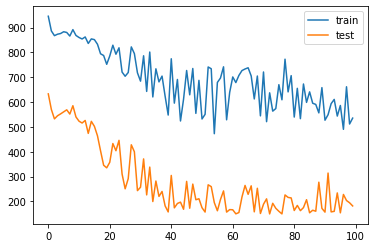

In [8]:
# LSTM model untuk seasonal
model = Sequential()
model.add(LSTM(jumlah_neuron, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(jumlah_neuron))
model.add(Dense(1))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=epooch_total, batch_size=size_batch, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [9]:
# make a prediction
yhat = model.predict(test_X)
yhat

array([[899.80853],
       [899.80853],
       [899.80853],
       [899.7633 ],
       [899.52423],
       [899.80273],
       [899.80853],
       [899.80853],
       [899.80853],
       [899.80853]], dtype=float32)

In [11]:
# jadikan list semua hasil prediksi
hasil_lstm = ndarray.tolist(yhat)
list_evaluasi = validation['case'].tolist()
length = len(list_evaluasi)
hasil_final = list()

for i in range(length):
    result_single = hasil_lstm[i]
    result_single = result_single[0]
    tambah = result_single
    hasil_final.append(tambah)
    #print('hasil tambah',tambah)

hasil_final

[899.8085327148438,
 899.8085327148438,
 899.8085327148438,
 899.7633056640625,
 899.5242309570312,
 899.802734375,
 899.8085327148438,
 899.8085327148438,
 899.8085327148438,
 899.8085327148438]

In [12]:
mse = mean_squared_error(list_evaluasi, hasil_final)
print("Hasil MSE :", mse)

Hasil MSE : 48356.09654854089


In [13]:
rmse = mean_squared_error(list_evaluasi, hasil_final, squared=False)
rmse

219.90019679059154

In [14]:
mae = mean_absolute_error(list_evaluasi, hasil_final)
mae

176.11329345703126